# Sequence to Sequence Models for Timeseries Regression

<img src="./images/Seq2Seq for regression.png" />

In [1]:
# Imports
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
import torch
import torch.utils.data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from pathlib import Path
from tqdm.auto import tqdm

## Parameters

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'using {device}')


window_past = 48
window_future = 48
batch_size = 32
num_workers = 0
use_future = False # Cheat!

using cuda


## Load data

In [3]:

def get_smartmeter_df(indir=Path('../../data/processed/smartmeter')):
    """
    Data loading and cleanding is always messy, so understand this code is optional.
    """
    
    # Load csv files
    csv_files = sorted((indir/'halfhourly_dataset').glob('*.csv'))[:1]
    
    # concatendate them
    df = pd.concat([pd.read_csv(f, parse_dates=[1], na_values=['Null']) for f in csv_files])

    # Take the mean over all houses
    df = df.groupby('tstp').mean()

    # Load weather data
    df_weather = pd.read_csv(indir/'weather_hourly_darksky.csv', parse_dates=[3])
    use_cols = ['visibility', 'windBearing', 'temperature', 'time', 'dewPoint',
           'pressure', 'apparentTemperature', 'windSpeed', 
           'humidity']
    df_weather = df_weather[use_cols].set_index('time')
    df_weather = df_weather.resample('30T').ffill()  # Resample to match energy data    

    # Join weather and energy data
    df = pd.concat([df, df_weather], 1).dropna()    
    
    # Also find bank holidays
    df_hols = pd.read_csv(indir/'uk_bank_holidays.csv', parse_dates=[0])
    holidays = set(df_hols['Bank holidays'].dt.round('D'))  

    time = df.index.to_series()
    df['holiday'] = time.apply(lambda dt:dt.floor('D') in holidays).astype(int)

    # Add time features    
    df["month"] = time.dt.month
    df['day'] = time.dt.day
    df['week'] = time.dt.week
    df['hour'] = time.dt.hour
    df['minute'] = time.dt.minute
    df['dayofweek'] = time.dt.dayofweek

    # Drop nan and 0's
    df = df[df['energy(kWh/hh)']!=0]
    df = df.dropna()

    # sort by time
    df = df.sort_index()
    
    return df

Our dataset is the london smartmeter data. But at half hour intervals

In [4]:
df = get_smartmeter_df()

df = df.tail(5000) # Just use last 10k rows
df

/home/wassname/anaconda/envs/deep_ml_curriculum/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday,month,day,week,hour,minute,dayofweek
2013-11-15 20:30:00,0.804111,13.92,322.0,6.40,1.93,1033.96,6.40,1.31,0.73,0,11,15,46,20,30,4
2013-11-15 21:00:00,0.731533,11.49,303.0,4.79,1.69,1034.14,4.79,0.76,0.80,0,11,15,46,21,0,4
2013-11-15 21:30:00,0.693133,11.49,303.0,4.79,1.69,1034.14,4.79,0.76,0.80,0,11,15,46,21,30,4
2013-11-15 22:00:00,0.659689,10.40,247.0,3.84,1.28,1034.30,3.84,0.52,0.83,0,11,15,46,22,0,4
2013-11-15 22:30:00,0.690111,10.40,247.0,3.84,1.28,1034.30,3.84,0.52,0.83,0,11,15,46,22,30,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-27 22:00:00,0.678429,14.00,216.0,4.10,1.64,1005.67,1.41,3.02,0.84,0,2,27,9,22,0,3
2014-02-27 22:30:00,0.652071,14.00,216.0,4.10,1.64,1005.67,1.41,3.02,0.84,0,2,27,9,22,30,3
2014-02-27 23:00:00,0.545190,14.03,200.0,3.93,1.61,1004.62,1.42,2.75,0.85,0,2,27,9,23,0,3
2014-02-27 23:30:00,0.442571,14.03,200.0,3.93,1.61,1004.62,1.42,2.75,0.85,0,2,27,9,23,30,3


In [5]:
# Normalise
from sklearn.preprocessing import StandardScaler
input_columns = df.columns[1:]
out_columns = df.columns[:1]
scaler_input = StandardScaler()
scaler_output = StandardScaler()
df_norm = df.copy()
df_norm[input_columns] = scaler_input.fit_transform(df[input_columns])
df_norm[out_columns] = scaler_output.fit_transform(df[out_columns])
df_norm.describe()

,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday,month,day,week,hour,minute,dayofweek
count,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,5.000000e+03,5000.000000,5.000000e+03,5000.0000,5.000000e+03
mean,-3.979039e-17,-7.958079e-17,5.684342e-17,-1.875833e-16,1.364242e-16,8.367351e-15,-8.526513e-17,-1.136868e-17,-6.139089e-16,-6.821210e-17,0.000000,-6.821210e-17,0.000000,-6.004086e-17,0.0000,-3.694822e-17
std,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100,1.000100e+00,1.000100,1.000100e+00,1.0001,1.000100e+00
min,-1.637408e+00,-3.803164e+00,-3.197659e+00,-3.377334e+00,-2.821109e+00,-2.107109e+00,-2.984027e+00,-1.812526e+00,-3.494843e+00,-1.722035e-01,-0.979184,-1.801828e+00,-1.025133,-1.661374e+00,-1.0000,-1.491544e+00
25%,-9.046472e-01,-3.497715e-01,-4.139248e-01,-7.010171e-01,-7.535234e-01,-7.689744e-01,-6.707308e-01,-6.801678e-01,-6.884337e-01,-1.722035e-01,-0.979184,-8.712880e-01,-0.889489,-7.954739e-01,-1.0000,-9.930333e-01
50%,-6.592261e-02,3.268114e-01,3.749164e-02,9.181657e-02,-9.949116e-02,-2.162770e-02,-1.309616e-01,-1.658219e-01,1.750767e-01,-1.722035e-01,-0.782836,5.925214e-02,-0.708631,7.042657e-02,0.0000,3.988085e-03
75%,6.792759e-01,5.593868e-01,5.039553e-01,7.085767e-01,7.693552e-01,7.595252e-01,5.175326e-01,5.568540e-01,7.147708e-01,-1.722035e-01,1.180636,8.734748e-01,1.145169,9.363270e-01,1.0000,1.001009e+00
max,3.072324e+00,1.771598e+00,2.204291e+00,2.860697e+00,2.771730e+00,2.102583e+00,2.888662e+00,4.044637e+00,1.902098e+00,5.807084e+00,1.180636,1.687697e+00,1.280813,1.657911e+00,1.0000,1.499520e+00


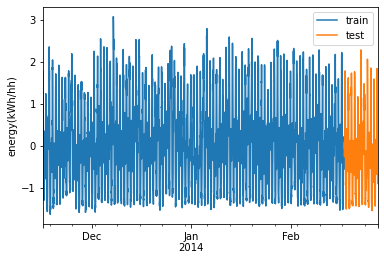

In [6]:
# split data
n_split = -int(len(df)*0.1)
df_train = df_norm[:n_split]
df_test = df_norm[n_split:]

# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.ylabel('energy(kWh/hh)')
plt.legend()

## Pytorch Dataset

A sequence to sequence model needs a sequence of inputs and a sequence of outputs. 

Lets use the pytorch dataset class to provide an array interface that makes these sequences on the fly

- x_past: The past inputs
- y_past: The past labels
- x_future: (optional) The future inputs
- y_future: The labels

In [7]:
class SmartMeterSeq2SeqDataSet(torch.utils.data.Dataset):
    """
    Takes in dataframe and returns sequences through time.
    
    Returns x_past, y_past, x_future, etc.
    """
    
    def __init__(self, df, window_past=40, window_future=10, label_names=['energy(kWh/hh)']):
        self.df = df        
        self.window_past = window_past
        self.window_future = window_future
        self.label_names = label_names

    def get_rows(self, i):
        """Get dataframe rows."""
        
        # Get past and future rows
        rows = self.df.iloc[i : i + (self.window_past + self.window_future)].copy()
        
        # Add a feature, relative days since present time
        rows['tsp'] = (rows.index - rows.index[self.window_past]).total_seconds() / 86400.0
        
        # Add second feature, is_future
        rows['is_past'] = rows['tsp'] < 0

        # split into x and y, input and labels
        x = rows.drop(columns=self.label_names).copy()
        y = rows[self.label_names].copy()
        
        # Split into future and past
        x_past = x[:self.window_past]
        y_past = y[:self.window_past]
        x_future = x[self.window_past:]
        y_future = y[self.window_past:]
        return x_past, y_past, x_future, y_future


    def __getitem__(self, i):
        data = self.get_rows(i)
        # From dataframe to torch
        return [torch.Tensor(d.values.astype(float)) for d in data]
        
    def __len__(self):
        return len(self.df) - (self.window_past + self.window_future)
    
    def __repr__(self):
        return f'<{type(self).__name__}(df.shape={self.df.shape})>'

In [8]:
ds_train = SmartMeterSeq2SeqDataSet(df_train, window_past=window_past, window_future=window_future)
ds_test = SmartMeterSeq2SeqDataSet(df_test, window_past=window_past, window_future=window_future)
print(ds_train)
print(ds_test)

<SmartMeterSeq2SeqDataSet(df.shape=(4500, 16))>
<SmartMeterSeq2SeqDataSet(df.shape=(500, 16))>


,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday,month,day,week,hour,minute,dayofweek,tsp,is_past
2013-11-17 01:30:00,-0.959401,1.737827,0.627080,0.704144,1.352282,1.176822,-1.521462,0.175077,-0.172203,0.984289,0.059252,1.009525,-1.517058,1.0,1.499520,0.000000,False
2013-11-17 02:00:00,-1.220167,1.286410,0.498295,0.681128,1.341123,1.078121,-1.521462,0.283016,-0.172203,0.984289,0.059252,1.009525,-1.372741,-1.0,1.499520,0.020833,False
2013-11-17 02:30:00,-1.220167,1.286410,0.498295,0.681128,1.341123,1.078121,-1.521462,0.283016,-0.172203,0.984289,0.059252,1.009525,-1.372741,1.0,1.499520,0.041667,False
2013-11-17 03:00:00,-1.086260,1.617449,0.606957,0.715652,1.312897,1.161400,-1.493552,0.175077,-0.172203,0.984289,0.059252,1.009525,-1.228424,-1.0,1.499520,0.062500,False
2013-11-17 03:30:00,-1.086260,1.617449,0.606957,0.715652,1.312897,1.161400,-1.493552,0.175077,-0.172203,0.984289,0.059252,1.009525,-1.228424,1.0,1.499520,0.083333,False
2013-11-17 04:00:00,-0.920638,1.948488,0.482197,0.681128,1.280731,1.065784,-1.421783,0.283016,-0.172203,0.984289,0.059252,1.009525,-1.084107,-1.0,1.499520,0.104167,False
2013-11-17 04:30:00,-0.920638,1.948488,0.482197,0.681128,1.280731,1.065784,-1.421783,0.283016,-0.172203,0.984289,0.059252,1.009525,-1.084107,1.0,1.499520,0.125000,False
2013-11-17 05:00:00,-0.631681,2.189243,0.635129,0.661948,1.253818,1.182991,-1.326091,0.067138,-0.172203,0.984289,0.059252,1.009525,-0.939791,-1.0,1.499520,0.145833,False
2013-11-17 05:30:00,-0.631681,2.189243,0.635129,0.661948,1.253818,1.182991,-1.326091,0.067138,-0.172203,0.984289,0.059252,1.009525,-0.939791,1.0,1.499520,0.166667,False
2013-11-17 06:00:00,-0.864256,-3.152518,0.643178,0.665784,1.218370,1.004096,-1.230398,0.067138,-0.172203,0.984289,0.059252,1.009525,-0.795474,-1.0,1.499520,0.187500,False


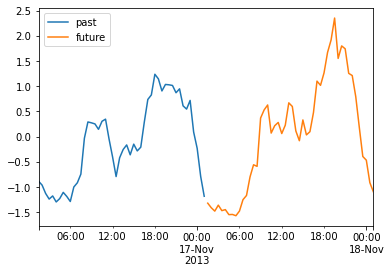

In [9]:
# We can get rows
x_past, y_past, x_future, y_future = ds_train.get_rows(10)


# Plot one instance, this is what the model sees
y_past['energy(kWh/hh)'].plot(label='past')
y_future['energy(kWh/hh)'].plot(ax=plt.gca(), label='future')
plt.legend()

# Notice we've added on two new columns tsp (time since present) and is_past
x_future

In [10]:
# and treat it like an array
print(len(ds_train))
ds_train[0][0].shape

4404


torch.Size([48, 17])

## Model

In [11]:

class Seq2SeqNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=32, lstm_layers=2, lstm_dropout=0, _min_std = 0.05):
        super().__init__()
        self._min_std = _min_std

        self.encoder = nn.LSTM(
            input_size=input_size + output_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=lstm_layers,
            dropout=lstm_dropout,
        )
        self.mean = nn.Linear(hidden_size, output_size)
        self.std = nn.Linear(hidden_size, output_size)

    def forward(self, context_x, context_y, target_x, target_y=None):
        past = torch.cat([context_x, context_y], -1)
        
        # Placeholder
        B, S, _ = target_x.shape
        target_y_fake = torch.zeros((B, S, 1)).to(device)
        
        if not use_future:
            # Normally you would put weather forecasts here. But we are cheating by putting
            # Weather measurements... we can try with and without
            target_x = (target_x * 0)
        future = torch.cat([target_x, target_y_fake], -1)
        x = torch.cat([past, future], 1).detach()
        
        outputs, _ = self.encoder(x)        
        
        # We only want the future
        outputs = outputs[:, -S:]
        
        # outputs: [B, T, num_direction * H]
        mean = self.mean(outputs)      
        
        log_sigma = self.std(outputs)
        log_sigma = torch.clamp(log_sigma, np.log(self._min_std), -np.log(self._min_std))

        sigma = torch.exp(log_sigma)
        y_dist = torch.distributions.Normal(mean, sigma)
        return y_dist



In [12]:
input_size = x_past.shape[-1]
output_size = y_future.shape[-1]

model = Seq2SeqNet(input_size, output_size,
                   hidden_size=32, 
                   lstm_layers=2, 
                   lstm_dropout=0).to(device)
model

Seq2SeqNet(
  (encoder): LSTM(18, 32, num_layers=2, batch_first=True)
  (mean): Linear(in_features=32, out_features=1, bias=True)
  (std): Linear(in_features=32, out_features=1, bias=True)
)

In [13]:
# Init the optimiser, and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Concept: Likelihood

In this notebook we wont just predict an answer, but how wrong we might be: the mean and standard deviation.

So instead of the mean squared error, like in most regression problems, we are going to be predicting a normal distribution, and minimising the [Negative Log Likihood (NLL)](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html). 

This means our model will output a distribution, and we will try to make sure it overlaps with the true answer as much possible. This is the concept of likelihood, which is illustrated below.

The image below shows a distribution in blue, then possible answers in red.

/home/wassname/anaconda/envs/deep_ml_curriculum/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


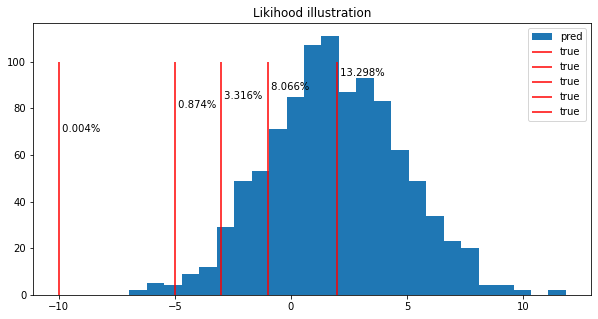

In [14]:
# Here is out distribution
y_dist = torch.distributions.Normal(2, 3)
# We can sample from it. Lets see the predictions:
n = y_dist.sample_n(1000).numpy()

# We can also get the probability of an answer being sampled from the distribution
y_dist.log_prob(2).exp() # log and exp cancel out

plt.figure(figsize=(10, 5))
plt.title('Likihood illustration')
plt.hist(n, bins=25, label='pred')
for y_true in [-10, -5, -3, -1, 2]:
    prob = y_dist.log_prob(y_true).exp().numpy()
    plt.vlines(x=y_true, ymin=0, ymax=100, color='r', label=f'true')
    plt.text(x=y_true, y=90+y_true*2, s=f'{prob: 3.3%}')
plt.legend()
plt.show()

## Training

In [15]:
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        x = x.cpu().detach().numpy()
    return x

In [16]:
def train_epoch(ds, model, bs=128):
    model.train()

    training_loss = []

    # Put data into a loader
    load_train = torch.utils.data.dataloader.DataLoader(
        ds, 
        batch_size=bs, pin_memory=True, num_workers=num_workers,
        shuffle=True,
    )

    for batch in tqdm(load_train, leave=False, desc='train'):
        # make it a pytorch gpu variable
        x_past, y_past, x_future, y_future = [d.to(device) for d in batch]
        
        optimizer.zero_grad()
        y_dist = model(x_past, y_past, x_future, y_future)
        loss = -y_dist.log_prob(y_future).mean()
        
        # Backprop
        loss.backward()
        optimizer.step()

        # Record stats
        training_loss.append(loss.item())

    return np.mean(training_loss)

def test_epoch(ds, model, bs=512):
    model.eval()

    test_loss = []
    load_test = torch.utils.data.dataloader.DataLoader(ds, batch_size=bs)
    for batch in tqdm(load_test, leave=False, desc='test'):
        x_past, y_past, x_future, y_future = [d.to(device) for d in batch]
        with torch.no_grad():
            y_dist = model(x_past, y_past, x_future, y_future)
            loss = -y_dist.log_prob(y_future).mean()

        test_loss.append(loss.item())

    return np.mean(test_loss)

def training_loop(ds_train, ds_test, model, epochs=1, bs=128):
    all_losses = []
    try:
        test_loss = test_epoch(ds_test, model)
        print(
                f"Start: Test Loss = {test_loss:.2f}"
            )
        for epoch in tqdm(range(epochs), desc='epochs'):
            loss = train_epoch(ds_train, model, bs=bs)
            print(f"Epoch {epoch+1}/{epochs}: Training Loss = {loss:.2f}")
            
            test_loss = test_epoch(ds_test, model)
            print(
                f"Epoch {epoch+1}/{epochs}: Test Loss = {test_loss:.2f}"
            )
            print("-" * 50)
        
            all_losses.append([loss, test_loss])
            
    except KeyboardInterrupt:
        # This lets you stop manually. and still get the results
        pass

    # Visualising the results
    all_losses = np.array(all_losses)
    plt.plot(all_losses[:, 0], label="Training")
    plt.plot(all_losses[:, 1], label="Test")
    plt.title("Loss")
    plt.legend()
    
    return all_losses

Start: Test Loss = 1.39


Epoch 1/14: Training Loss = 1.17


Epoch 1/14: Test Loss = 0.69
--------------------------------------------------


Epoch 2/14: Training Loss = 0.42


Epoch 2/14: Test Loss = 0.47
--------------------------------------------------


Epoch 3/14: Training Loss = 0.27


Epoch 3/14: Test Loss = 0.44
--------------------------------------------------


Epoch 4/14: Training Loss = 0.25


Epoch 4/14: Test Loss = 0.42
--------------------------------------------------


Epoch 5/14: Training Loss = 0.23


Epoch 5/14: Test Loss = 0.51
--------------------------------------------------


Epoch 6/14: Training Loss = 0.22


Epoch 6/14: Test Loss = 0.49
--------------------------------------------------


Epoch 7/14: Training Loss = 0.22


Epoch 7/14: Test Loss = 0.52
--------------------------------------------------


Epoch 8/14: Training Loss = 0.21


Epoch 8/14: Test Loss = 0.48
--------------------------------------------------


Epoch 9/14: Training Loss = 0.20


Epoch 9/14: Test Loss = 0.45
--------------------------------------------------


Epoch 10/14: Training Loss = 0.19


Epoch 10/14: Test Loss = 0.61
--------------------------------------------------


Epoch 11/14: Training Loss = 0.18


Epoch 11/14: Test Loss = 0.54
--------------------------------------------------


Epoch 12/14: Training Loss = 0.17


Epoch 12/14: Test Loss = 0.51
--------------------------------------------------


Epoch 13/14: Training Loss = 0.16


Epoch 13/14: Test Loss = 0.48
--------------------------------------------------


Epoch 14/14: Training Loss = 0.14


Epoch 14/14: Test Loss = 0.54
--------------------------------------------------



1

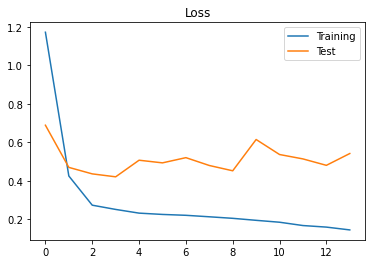

In [17]:
training_loop(ds_train, ds_test, model, epochs=14, bs=batch_size)
1

# Predict

When we generate prediction in a sequence to sequence model we start at a time, then predict N steps into the future. So we have 2 dimensions: source time, target time.

But we also care about how far we were predicting into the future, so we have 3 dimensions: source time, target time, time ahead.

It's hard to use pandas for data with more than 2 dimensions, so we will use xarray. Xarray has an interface similar to pandas but can have N dimensions.

In [18]:
import xarray as xr 

load_test = torch.utils.data.dataloader.DataLoader(ds_test, batch_size=batch_size)
xrs = []
for i, batch in enumerate(tqdm(load_test, desc='predict')):
    model.eval()
    with torch.no_grad():
        x_past, y_past, x_future, y_future = [d.to(device) for d in batch]
        y_dist = model(x_past, y_past, x_future, y_future)
        log_prob = y_dist.log_prob(y_future)

        # Convert to numpy
        mean = to_numpy(y_dist.loc.squeeze(-1))
        std = to_numpy(y_dist.scale.squeeze(-1))
        log_prob = to_numpy(log_prob.squeeze(-1))
        y_future = to_numpy(y_future.squeeze(-1))
        y_past = to_numpy(y_past.squeeze(-1))    
    
    # Make an xarray.Dataset for the data
    bs = y_future.shape[0]
    t_source = ds_test.df.index[i:i+bs].values
    t_ahead = pd.timedelta_range(0, periods=ds_test.window_future, freq='30T').values
    t_behind = pd.timedelta_range(end=-pd.Timedelta('30T'), periods=ds_test.window_past, freq='30T')
    xr_out = xr.Dataset(
        {
            # Format> name: ([dimensions,...], array),
            "y_past": (["t_source", "t_behind",], y_past),
            "log_prob": (["t_source", "t_ahead",], log_prob),
            "y_pred": (["t_source", "t_ahead",], mean),
            "y_pred_std": (["t_source", "t_ahead",], std),
            "y_true": (["t_source", "t_ahead",], y_future),
        },
        coords={"t_source": t_source, "t_ahead": t_ahead, "t_behind": t_behind},
    )
    xrs.append(xr_out)
    
# Join all batches
ds_preds = xr.concat(xrs, dim="t_source")
ds_preds

<xarray.Dataset>
Dimensions:     (t_ahead: 48, t_behind: 48, t_source: 404)
Coordinates:
  * t_source    (t_source) datetime64[ns] 2014-02-17T14:30:00 ... 2014-02-18T...
  * t_ahead     (t_ahead) timedelta64[ns] 00:00:00 00:30:00 ... 23:30:00
  * t_behind    (t_behind) timedelta64[ns] -1 days +00:00:00 ... -1 days +23:...
Data variables:
    y_past      (t_source, t_behind) float32 -0.060392648 ... -0.49454385
    log_prob    (t_source, t_ahead) float32 0.2837342 -1.1657104 ... -0.78035533
    y_pred      (t_source, t_ahead) float32 -0.14995551 ... 0.12694412
    y_pred_std  (t_source, t_ahead) float32 0.28864595 0.28705207 ... 0.24397394
    y_true      (t_source, t_ahead) float32 -0.23147607 ... -0.26220933

In [19]:
# undo scaling on y
ds_preds['y_pred_std'].values = ds_preds.y_pred_std * scaler_output.scale_
ds_preds['y_past'].values =  scaler_output.inverse_transform(ds_preds.y_past)
ds_preds['y_pred'].values =  scaler_output.inverse_transform(ds_preds.y_pred)
ds_preds['y_true'].values =  scaler_output.inverse_transform(ds_preds.y_true)

In [20]:
# Add some derived coordinates
# The target time, is a function of the source time, and how far we predict ahead
ds_preds = ds_preds.assign_coords(t_target=ds_preds.t_source+ds_preds.t_ahead)

ds_preds = ds_preds.assign_coords(t_past=ds_preds.t_source+ds_preds.t_behind)
ds_preds

<xarray.Dataset>
Dimensions:     (t_ahead: 48, t_behind: 48, t_source: 404)
Coordinates:
  * t_source    (t_source) datetime64[ns] 2014-02-17T14:30:00 ... 2014-02-18T...
  * t_ahead     (t_ahead) timedelta64[ns] 00:00:00 00:30:00 ... 23:30:00
  * t_behind    (t_behind) timedelta64[ns] -1 days +00:00:00 ... -1 days +23:...
    t_target    (t_source, t_ahead) datetime64[ns] 2014-02-17T14:30:00 ... 20...
    t_past      (t_source, t_behind) datetime64[ns] 2014-02-16T14:30:00 ... 2...
Data variables:
    y_past      (t_source, t_behind) float32 0.4783721 0.5043023 ... 0.40135714
    log_prob    (t_source, t_ahead) float32 0.2837342 -1.1657104 ... -0.78035533
    y_pred      (t_source, t_ahead) float32 0.46248436 0.469395 ... 0.51160413
    y_pred_std  (t_source, t_ahead) float64 0.0512 0.05092 ... 0.05316 0.04328
    y_true      (t_source, t_ahead) float32 0.44802326 0.38134885 ... 0.44257143

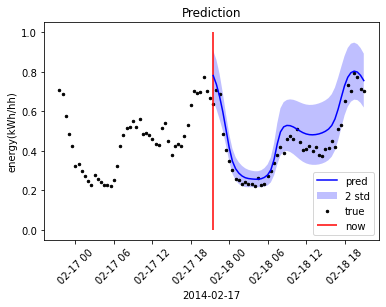

In [30]:
# plot a prediction
i=14
d = ds_preds.isel(t_source=i)

xf = d.t_target
yp = d.y_pred
s = d.y_pred_std

plt.fill_between(xf, yp-2*s, yp+2*s, alpha=0.25,
        facecolor="b",
        interpolate=True,
        label="2 std",)
plt.plot(xf, yp, label='pred', c='b')


yt = d.y_true
plt.scatter(xf, yt, label='true', c='k', s=6)

plt.scatter(
    d.t_past,
    d.y_past,
    c='k',
    s=6
)
plt.vlines(x=d.t_source.squeeze(), ymin=0, ymax=1, label='now', color='r')

now=pd.Timestamp(d.t_source.squeeze().values)
plt.title('Prediction')
plt.xlabel(f'{now.date()}')
plt.ylabel('energy(kWh/hh)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Error vs time ahead

Text(0.5, 1.0, 'NLL vs time (no. samples=404)')

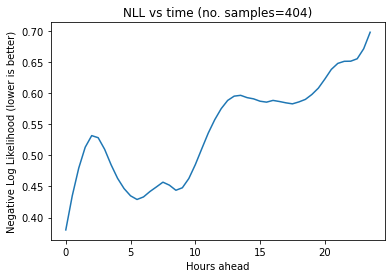

In [25]:
# plot error vs time
d = ds_preds.mean('t_source') # Mean over all predictions
x = d.t_ahead.dt.seconds/60/60
y = -d.log_prob
n = len(ds_preds.t_source)
plt.plot(x, y)
plt.ylabel('Negative Log Likelihood (lower is better)')
plt.xlabel('Hours ahead')
plt.title(f'NLL vs time (no. samples={n})')

Text(0.5, 1.0, 'Prob vs time (no. samples=404)')

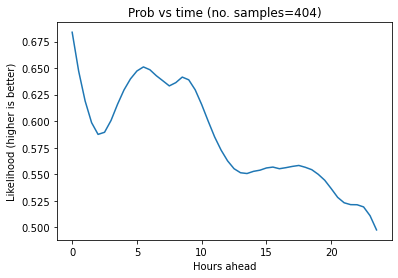

In [26]:
# plot likelihod vs time
d = ds_preds.mean('t_source') # Mean over all predictions
x = d.t_ahead.dt.seconds/60/60
y =  np.exp(d.log_prob)
n = len(ds_preds.t_source)
plt.plot(x, y)
plt.ylabel('Likelihood (higher is better)')
plt.xlabel('Hours ahead')
plt.title(f'Prob vs time (no. samples={n})')

Text(0.5, 1.0, 'Prob vs time (no. samples=404)')

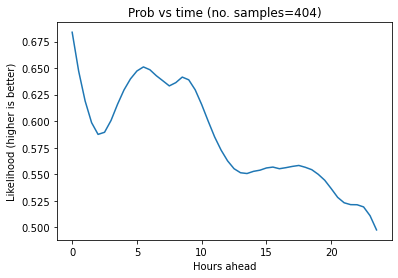

In [59]:
# plot likelihod vs time
d = ds_preds.mean('t_source') # Mean over all predictions
x = d.t_ahead.dt.seconds/60/60
y =  np.exp(d.log_prob)
n = len(ds_preds.t_source)
plt.plot(x, y)
plt.ylabel('Likelihood (higher is better)')
plt.xlabel('Hours ahead')
plt.title(f'Prob vs time (no. samples={n})')

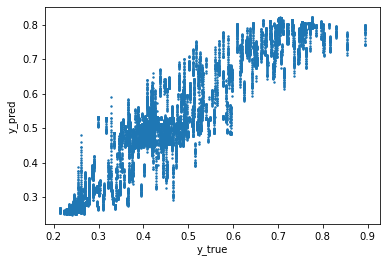

In [36]:
# Some people are used to scatter plots, it's easy with xarray
ds_preds.plot.scatter('y_true', 'y_pred', s=2)